# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

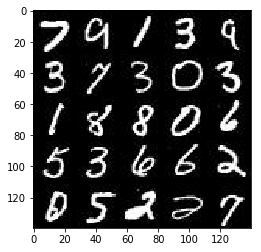

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

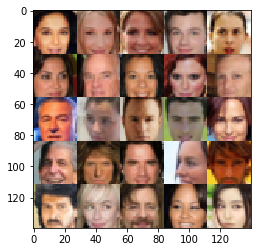

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [1]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0


/Users/stephen/anaconda/envs/tensorflow/lib/python3.5/site-packages/ipykernel/__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [2]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """

    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim))
    lr = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Helpers

I wrote these to remove the deplicated code from all over the place and reduce copy-paste errors

In [3]:
def lrelu(tensor, alpha=0.2):
    """Calculate a leaky ReLU with the supplied tensor and alpha"""
    return tf.maximum(tensor, tensor * alpha)

In [4]:
def conv2d_leaky(inputs, outputs, kernel_size=5, strides=2, padding='same', alpha=0.2):
    layer = tf.layers.conv2d(inputs, outputs, kernel_size, strides, padding)
    return lrelu(layer, alpha) if alpha != -1 else layer

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [5]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    drop_rate = 0.1

    # image shape: batch_count, 28, 28, 3
    with tf.variable_scope('discriminator', reuse=reuse):
        
        conv0 = conv2d_leaky(images, 32, strides=1, padding='same')
        conv0 = tf.layers.dropout(conv0, drop_rate)
        
        conv1 = conv2d_leaky(images, 64, strides=2, padding='same')
        conv1 = tf.layers.batch_normalization(conv1, training=False)
        conv1 = tf.layers.dropout(conv1, drop_rate)
        # now 14x14x64

        conv2 = conv2d_leaky(conv1, 128)
        conv2 = tf.layers.batch_normalization(conv2, training=False)
        conv2 = tf.layers.dropout(conv2, drop_rate)
        # now 7x7x128
                
        conv3 = conv2d_leaky(conv2, 256, strides=2, padding='same')
        conv3 = tf.layers.batch_normalization(conv3, training=False)
        conv3 = tf.layers.dropout(conv3, drop_rate)
        # now 4x4x256
        
        conv4 = conv2d_leaky(conv3, 512, strides=1, padding='same')
        conv4 = tf.layers.batch_normalization(conv4, training=False)
        conv4 = tf.layers.dropout(conv4, drop_rate)
        
        
        flat = tf.reshape(conv4, (-1, 2 * 2 * 512))
        
        logits = tf.layers.dense(flat, 1)
        out = tf.nn.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [14]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """

    drop_rate = 0.1
    alpha = 0.1

    with tf.variable_scope('generator', reuse=not is_train):

        x1 = tf.layers.dense(z, 28 * 28 * 64,
                             kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                             bias_initializer=tf.contrib.layers.xavier_initializer())
        

        x1 = tf.reshape(x1, (-1, 28, 28, 64))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = lrelu(x1, alpha)

        
        x2 = tf.layers.conv2d_transpose(x1, 32, 5, strides=1, padding='same',
                                        kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                        bias_initializer=tf.contrib.layers.xavier_initializer())
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = lrelu(x2, alpha)
        x2 = tf.layers.dropout(x2, drop_rate, training=is_train)
        # 14x14x256 now


        
        # Output layer
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=1, padding='same', 
                                            kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                            bias_initializer=tf.contrib.layers.xavier_initializer())
        # 28x28x3 now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [21]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    # encapsulate the repeated logic
    def model_loss(logits, like_shape_for_labels, smoothing=1):
        return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=like_shape_for_labels))
    
    smoothing = 0.9 # factor to help with generalization
    
    # now actually calculate those losses
    d_loss_real = model_loss(d_logits_real, tf.ones_like(d_model_real) * smoothing)

    d_loss_fake = model_loss(d_logits_fake, tf.zeros_like(d_model_fake))
    g_loss = model_loss(d_logits_fake, tf.ones_like(d_model_fake))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [22]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    trainables = tf.trainable_variables()
    d_vars = [var for var in trainables if var.name.startswith('discriminator')]
    g_vars = [var for var in trainables if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [23]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """

    print("parameters:")
    print("\t epoch_count =", epoch_count)
    print("\t batch_size =", batch_size)
    print("\t z_dim =", z_dim)
    print("\t learning_rate =", learning_rate)
    print("\t beta1 =", beta1)
    print("\t data_shape =", data_shape)
    print("\t image_mode =", data_image_mode)
    
    data_set_size, width, height, channels = data_shape
    
    input_real, input_z, lr = model_inputs(width, height, channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    step = 0
    print_every = 20
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                step += 1
                
                batch_images *= 2
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Optimizers do their thing
                _ = sess.run(d_opt, feed_dict={ input_z: batch_z, input_real: batch_images, lr: learning_rate })

                # double dip for the Generator, see if it addresses the symptoms
                for _ in range(0, 2):
                    _ = sess.run(g_opt, feed_dict={ input_z: batch_z, input_real: batch_images, lr: learning_rate })
                
                if step % print_every == 0:
                    train_loss_d = d_loss.eval({ input_z: batch_z, input_real: batch_images })
                    train_loss_g = g_loss.eval({ input_z: batch_z })

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Step {}".format(step),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                if step % show_every == 0:
                    show_generator_output(sess, 10, input_z, channels, data_image_mode)

        # No return value because we are just churning on the data
        print("Training Complete")
        show_generator_output(sess, 16, input_z, channels, data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

parameters:
	 epoch_count = 2
	 batch_size = 32
	 z_dim = 100
	 learning_rate = 0.0001
	 beta1 = 0.4
	 data_shape = (60000, 28, 28, 1)
	 image_mode = L
Epoch 1/2... Step 20 Discriminator Loss: 1.1648... Generator Loss: 1.2399
Epoch 1/2... Step 40 Discriminator Loss: 0.8487... Generator Loss: 1.5533
Epoch 1/2... Step 60 Discriminator Loss: 0.3690... Generator Loss: 3.6009
Epoch 1/2... Step 80 Discriminator Loss: 1.2900... Generator Loss: 0.8748
Epoch 1/2... Step 100 Discriminator Loss: 1.0290... Generator Loss: 1.0879


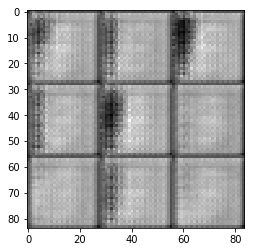

Epoch 1/2... Step 120 Discriminator Loss: 1.1677... Generator Loss: 1.3646
Epoch 1/2... Step 140 Discriminator Loss: 1.3058... Generator Loss: 1.0248
Epoch 1/2... Step 160 Discriminator Loss: 1.0863... Generator Loss: 1.4021
Epoch 1/2... Step 180 Discriminator Loss: 1.3278... Generator Loss: 0.7697
Epoch 1/2... Step 200 Discriminator Loss: 1.1295... Generator Loss: 1.0702


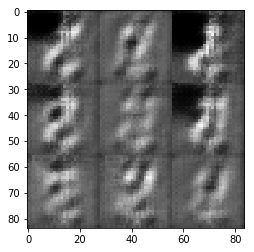

Epoch 1/2... Step 220 Discriminator Loss: 1.1327... Generator Loss: 0.8400
Epoch 1/2... Step 240 Discriminator Loss: 1.0899... Generator Loss: 1.0373
Epoch 1/2... Step 260 Discriminator Loss: 1.0080... Generator Loss: 1.3574
Epoch 1/2... Step 280 Discriminator Loss: 1.0995... Generator Loss: 0.8537
Epoch 1/2... Step 300 Discriminator Loss: 1.1718... Generator Loss: 0.7615


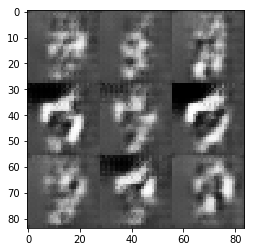

Epoch 1/2... Step 320 Discriminator Loss: 1.1730... Generator Loss: 2.0270
Epoch 1/2... Step 340 Discriminator Loss: 0.8941... Generator Loss: 1.8571
Epoch 1/2... Step 360 Discriminator Loss: 0.9540... Generator Loss: 1.1683
Epoch 1/2... Step 380 Discriminator Loss: 1.0749... Generator Loss: 1.2564
Epoch 1/2... Step 400 Discriminator Loss: 0.9138... Generator Loss: 1.4619


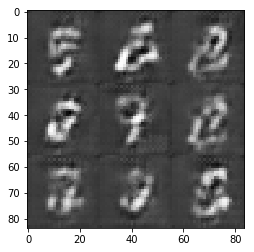

Epoch 1/2... Step 420 Discriminator Loss: 1.0826... Generator Loss: 1.3562
Epoch 1/2... Step 440 Discriminator Loss: 1.0214... Generator Loss: 1.5735
Epoch 1/2... Step 460 Discriminator Loss: 1.2298... Generator Loss: 0.7061
Epoch 1/2... Step 480 Discriminator Loss: 1.9938... Generator Loss: 0.2547
Epoch 1/2... Step 500 Discriminator Loss: 1.1348... Generator Loss: 0.8643


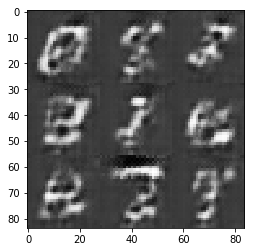

Epoch 1/2... Step 520 Discriminator Loss: 1.0918... Generator Loss: 0.9666
Epoch 1/2... Step 540 Discriminator Loss: 1.0861... Generator Loss: 1.0102
Epoch 1/2... Step 560 Discriminator Loss: 1.0606... Generator Loss: 1.0492
Epoch 1/2... Step 580 Discriminator Loss: 1.4031... Generator Loss: 0.5240
Epoch 1/2... Step 600 Discriminator Loss: 1.0669... Generator Loss: 1.2804


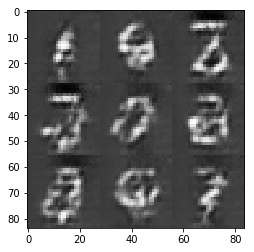

Epoch 1/2... Step 620 Discriminator Loss: 1.3176... Generator Loss: 2.5649
Epoch 1/2... Step 640 Discriminator Loss: 1.6921... Generator Loss: 2.6494
Epoch 1/2... Step 660 Discriminator Loss: 1.2038... Generator Loss: 1.8430
Epoch 1/2... Step 680 Discriminator Loss: 1.2325... Generator Loss: 0.5854
Epoch 1/2... Step 700 Discriminator Loss: 1.1403... Generator Loss: 1.7423


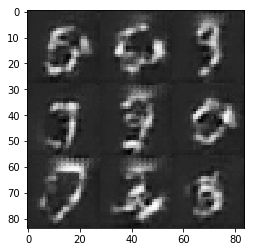

Epoch 1/2... Step 720 Discriminator Loss: 1.2368... Generator Loss: 0.6690
Epoch 1/2... Step 740 Discriminator Loss: 1.2639... Generator Loss: 0.6751
Epoch 1/2... Step 760 Discriminator Loss: 1.0280... Generator Loss: 1.8372
Epoch 1/2... Step 780 Discriminator Loss: 0.9604... Generator Loss: 1.8417
Epoch 1/2... Step 800 Discriminator Loss: 1.1903... Generator Loss: 0.7874


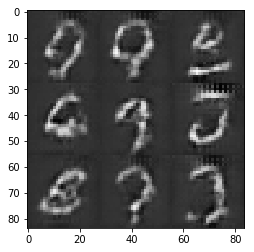

Epoch 1/2... Step 820 Discriminator Loss: 0.9650... Generator Loss: 1.7145
Epoch 1/2... Step 840 Discriminator Loss: 1.0290... Generator Loss: 1.6215
Epoch 1/2... Step 860 Discriminator Loss: 1.1386... Generator Loss: 1.1976
Epoch 1/2... Step 880 Discriminator Loss: 0.9466... Generator Loss: 1.2354
Epoch 1/2... Step 900 Discriminator Loss: 1.2553... Generator Loss: 0.6528


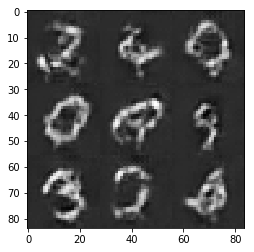

Epoch 1/2... Step 920 Discriminator Loss: 1.0202... Generator Loss: 1.6166
Epoch 1/2... Step 940 Discriminator Loss: 1.6650... Generator Loss: 0.3829
Epoch 1/2... Step 960 Discriminator Loss: 1.0166... Generator Loss: 1.2741
Epoch 1/2... Step 980 Discriminator Loss: 1.1150... Generator Loss: 0.9630
Epoch 1/2... Step 1000 Discriminator Loss: 1.0286... Generator Loss: 1.2887


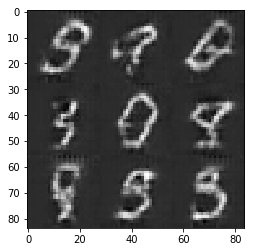

Epoch 1/2... Step 1020 Discriminator Loss: 0.9520... Generator Loss: 1.7534
Epoch 1/2... Step 1040 Discriminator Loss: 1.0763... Generator Loss: 0.7876
Epoch 1/2... Step 1060 Discriminator Loss: 0.8604... Generator Loss: 1.6129
Epoch 1/2... Step 1080 Discriminator Loss: 1.3037... Generator Loss: 0.6703
Epoch 1/2... Step 1100 Discriminator Loss: 1.1173... Generator Loss: 1.5484


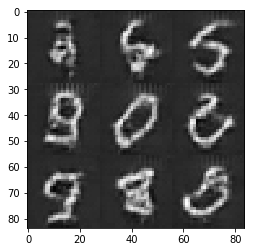

Epoch 1/2... Step 1120 Discriminator Loss: 0.9897... Generator Loss: 1.0941
Epoch 1/2... Step 1140 Discriminator Loss: 1.2213... Generator Loss: 0.8790
Epoch 1/2... Step 1160 Discriminator Loss: 0.9246... Generator Loss: 1.6689
Epoch 1/2... Step 1180 Discriminator Loss: 1.1365... Generator Loss: 0.8099
Epoch 1/2... Step 1200 Discriminator Loss: 1.0585... Generator Loss: 2.2392


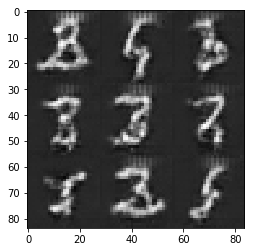

Epoch 1/2... Step 1220 Discriminator Loss: 0.9217... Generator Loss: 1.8312
Epoch 1/2... Step 1240 Discriminator Loss: 0.9890... Generator Loss: 1.0994
Epoch 1/2... Step 1260 Discriminator Loss: 1.0329... Generator Loss: 1.0345
Epoch 1/2... Step 1280 Discriminator Loss: 0.8760... Generator Loss: 1.2227
Epoch 2/2... Step 2940 Discriminator Loss: 0.9462... Generator Loss: 1.0941
Epoch 2/2... Step 2960 Discriminator Loss: 0.8265... Generator Loss: 1.6556
Epoch 2/2... Step 2980 Discriminator Loss: 0.7081... Generator Loss: 2.1768
Epoch 2/2... Step 3000 Discriminator Loss: 0.6027... Generator Loss: 2.6625


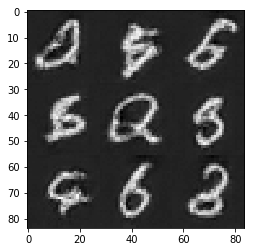

Epoch 2/2... Step 3020 Discriminator Loss: 1.0451... Generator Loss: 1.0369
Epoch 2/2... Step 3040 Discriminator Loss: 0.8965... Generator Loss: 2.3912
Epoch 2/2... Step 3060 Discriminator Loss: 1.1525... Generator Loss: 1.1897
Epoch 2/2... Step 3080 Discriminator Loss: 0.6747... Generator Loss: 1.9340
Epoch 2/2... Step 3100 Discriminator Loss: 0.7306... Generator Loss: 1.5282


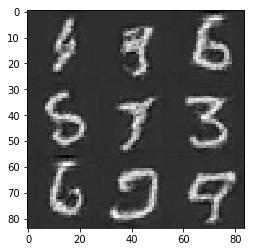

Epoch 2/2... Step 3120 Discriminator Loss: 1.1463... Generator Loss: 0.7758
Epoch 2/2... Step 3140 Discriminator Loss: 1.4102... Generator Loss: 2.1979
Epoch 2/2... Step 3160 Discriminator Loss: 0.8222... Generator Loss: 2.7740
Epoch 2/2... Step 3180 Discriminator Loss: 0.8540... Generator Loss: 1.4734
Epoch 2/2... Step 3200 Discriminator Loss: 0.6021... Generator Loss: 3.3707


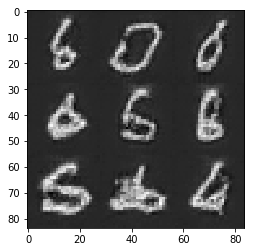

Epoch 2/2... Step 3220 Discriminator Loss: 1.1949... Generator Loss: 1.3923
Epoch 2/2... Step 3240 Discriminator Loss: 0.6660... Generator Loss: 2.2532
Epoch 2/2... Step 3260 Discriminator Loss: 0.8791... Generator Loss: 1.5444
Epoch 2/2... Step 3280 Discriminator Loss: 0.6694... Generator Loss: 2.4267
Epoch 2/2... Step 3300 Discriminator Loss: 0.6126... Generator Loss: 2.1895


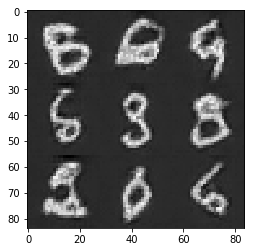

Epoch 2/2... Step 3320 Discriminator Loss: 0.7292... Generator Loss: 1.9359
Epoch 2/2... Step 3340 Discriminator Loss: 1.1221... Generator Loss: 4.4767
Epoch 2/2... Step 3360 Discriminator Loss: 0.7413... Generator Loss: 1.6628
Epoch 2/2... Step 3380 Discriminator Loss: 0.6915... Generator Loss: 2.1512
Epoch 2/2... Step 3400 Discriminator Loss: 0.6287... Generator Loss: 2.0887


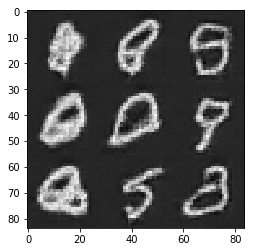

Epoch 2/2... Step 3420 Discriminator Loss: 1.0036... Generator Loss: 1.2399
Epoch 2/2... Step 3440 Discriminator Loss: 0.5993... Generator Loss: 2.5797
Epoch 2/2... Step 3460 Discriminator Loss: 0.7661... Generator Loss: 1.9393
Epoch 2/2... Step 3480 Discriminator Loss: 0.6729... Generator Loss: 2.6498
Epoch 2/2... Step 3500 Discriminator Loss: 0.6856... Generator Loss: 1.4742


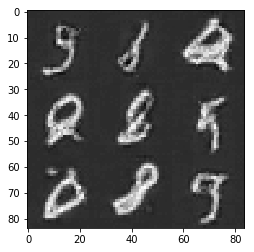

Epoch 2/2... Step 3520 Discriminator Loss: 0.8577... Generator Loss: 2.6761
Epoch 2/2... Step 3540 Discriminator Loss: 0.8757... Generator Loss: 1.5533
Epoch 2/2... Step 3560 Discriminator Loss: 0.8180... Generator Loss: 1.9296
Epoch 2/2... Step 3580 Discriminator Loss: 0.7153... Generator Loss: 2.4885
Epoch 2/2... Step 3600 Discriminator Loss: 1.4535... Generator Loss: 2.2960


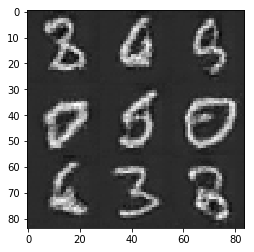

Epoch 2/2... Step 3620 Discriminator Loss: 0.7671... Generator Loss: 1.5892
Epoch 2/2... Step 3640 Discriminator Loss: 0.6747... Generator Loss: 2.5289
Epoch 2/2... Step 3660 Discriminator Loss: 0.6421... Generator Loss: 3.0889
Epoch 2/2... Step 3680 Discriminator Loss: 0.9787... Generator Loss: 1.0888
Epoch 2/2... Step 3700 Discriminator Loss: 1.1470... Generator Loss: 0.9395


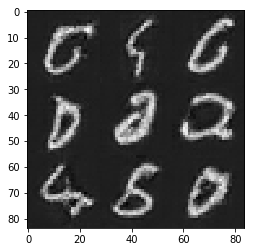

Epoch 2/2... Step 3720 Discriminator Loss: 0.6544... Generator Loss: 2.2230
Epoch 2/2... Step 3740 Discriminator Loss: 0.9791... Generator Loss: 1.6013


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0001
beta1 = 0.4


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

parameters:
	 epoch_count = 1
	 batch_size = 32
	 z_dim = 100
	 learning_rate = 0.0002
	 beta1 = 0.5
	 data_shape = (202599, 28, 28, 3)
	 image_mode = RGB
Epoch 1/1... Step 20 Discriminator Loss: 0.6353... Generator Loss: 4.1851
Epoch 1/1... Step 40 Discriminator Loss: 0.9919... Generator Loss: 1.5624
Epoch 1/1... Step 60 Discriminator Loss: 1.1143... Generator Loss: 1.6837
Epoch 1/1... Step 80 Discriminator Loss: 1.0987... Generator Loss: 1.3348
Epoch 1/1... Step 100 Discriminator Loss: 1.1193... Generator Loss: 1.1425


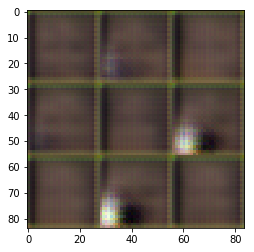

Epoch 1/1... Step 120 Discriminator Loss: 1.1020... Generator Loss: 1.7275
Epoch 1/1... Step 140 Discriminator Loss: 1.0305... Generator Loss: 2.3353
Epoch 1/1... Step 160 Discriminator Loss: 1.1903... Generator Loss: 1.9931
Epoch 1/1... Step 180 Discriminator Loss: 1.0353... Generator Loss: 1.7454
Epoch 1/1... Step 200 Discriminator Loss: 1.1285... Generator Loss: 2.4218


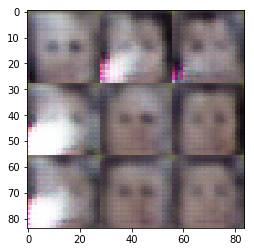

Epoch 1/1... Step 220 Discriminator Loss: 1.2504... Generator Loss: 1.9447
Epoch 1/1... Step 240 Discriminator Loss: 1.1645... Generator Loss: 1.5999
Epoch 1/1... Step 260 Discriminator Loss: 1.0293... Generator Loss: 1.6569
Epoch 1/1... Step 280 Discriminator Loss: 1.2735... Generator Loss: 1.4501
Epoch 1/1... Step 300 Discriminator Loss: 1.0246... Generator Loss: 0.9530


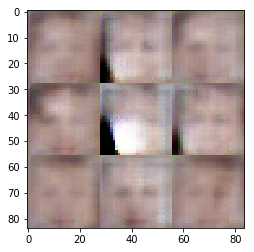

Epoch 1/1... Step 320 Discriminator Loss: 0.8958... Generator Loss: 2.3742
Epoch 1/1... Step 340 Discriminator Loss: 1.0544... Generator Loss: 1.7944
Epoch 1/1... Step 360 Discriminator Loss: 1.1432... Generator Loss: 1.9698
Epoch 1/1... Step 380 Discriminator Loss: 1.0238... Generator Loss: 1.5134
Epoch 1/1... Step 400 Discriminator Loss: 1.0971... Generator Loss: 1.9462


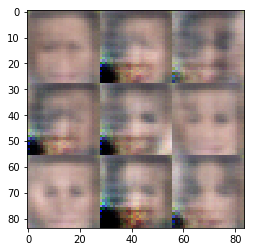

Epoch 1/1... Step 420 Discriminator Loss: 0.9727... Generator Loss: 2.3507
Epoch 1/1... Step 440 Discriminator Loss: 1.0295... Generator Loss: 1.9468
Epoch 1/1... Step 460 Discriminator Loss: 1.1580... Generator Loss: 2.0801
Epoch 1/1... Step 480 Discriminator Loss: 1.1133... Generator Loss: 1.8817
Epoch 1/1... Step 500 Discriminator Loss: 1.8959... Generator Loss: 0.8216


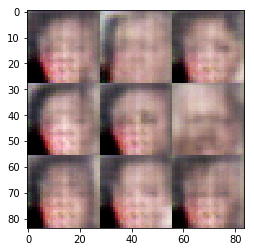

Epoch 1/1... Step 520 Discriminator Loss: 1.0236... Generator Loss: 1.3800
Epoch 1/1... Step 540 Discriminator Loss: 1.2407... Generator Loss: 1.6206
Epoch 1/1... Step 560 Discriminator Loss: 1.0978... Generator Loss: 1.7534
Epoch 1/1... Step 580 Discriminator Loss: 1.2160... Generator Loss: 1.3781
Epoch 1/1... Step 600 Discriminator Loss: 1.0511... Generator Loss: 1.6067


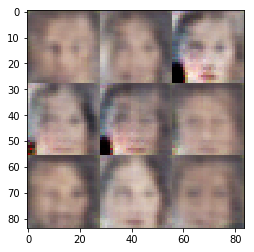

Epoch 1/1... Step 620 Discriminator Loss: 1.2501... Generator Loss: 1.2133
Epoch 1/1... Step 640 Discriminator Loss: 1.0478... Generator Loss: 2.3151
Epoch 1/1... Step 660 Discriminator Loss: 1.1754... Generator Loss: 1.3103
Epoch 1/1... Step 680 Discriminator Loss: 1.2509... Generator Loss: 2.2200
Epoch 1/1... Step 700 Discriminator Loss: 1.1747... Generator Loss: 1.7649


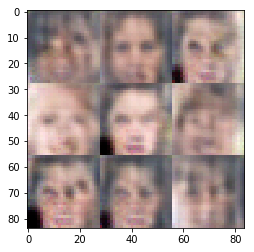

Epoch 1/1... Step 720 Discriminator Loss: 1.1438... Generator Loss: 1.7513
Epoch 1/1... Step 740 Discriminator Loss: 1.1641... Generator Loss: 1.3369
Epoch 1/1... Step 760 Discriminator Loss: 1.4328... Generator Loss: 1.0685
Epoch 1/1... Step 780 Discriminator Loss: 1.1345... Generator Loss: 1.4680
Epoch 1/1... Step 800 Discriminator Loss: 1.1997... Generator Loss: 1.8215


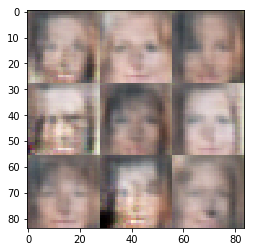

Epoch 1/1... Step 820 Discriminator Loss: 1.1699... Generator Loss: 2.1226
Epoch 1/1... Step 840 Discriminator Loss: 1.0714... Generator Loss: 1.5276
Epoch 1/1... Step 860 Discriminator Loss: 1.1638... Generator Loss: 1.4906
Epoch 1/1... Step 880 Discriminator Loss: 1.1894... Generator Loss: 0.7672
Epoch 1/1... Step 900 Discriminator Loss: 1.1747... Generator Loss: 1.7341


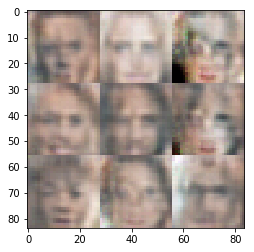

Epoch 1/1... Step 920 Discriminator Loss: 1.1172... Generator Loss: 1.6890
Epoch 1/1... Step 940 Discriminator Loss: 1.1952... Generator Loss: 1.1794
Epoch 1/1... Step 960 Discriminator Loss: 1.3800... Generator Loss: 1.9873
Epoch 1/1... Step 980 Discriminator Loss: 1.2860... Generator Loss: 1.6231
Epoch 1/1... Step 1000 Discriminator Loss: 1.2757... Generator Loss: 1.3754


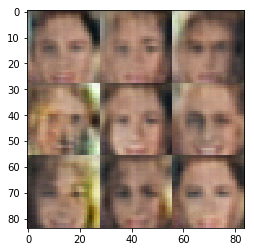

Epoch 1/1... Step 1020 Discriminator Loss: 1.4467... Generator Loss: 2.1184
Epoch 1/1... Step 1040 Discriminator Loss: 1.4942... Generator Loss: 1.3466
Epoch 1/1... Step 1060 Discriminator Loss: 1.1994... Generator Loss: 1.4490
Epoch 1/1... Step 1080 Discriminator Loss: 1.3766... Generator Loss: 1.2867
Epoch 1/1... Step 1100 Discriminator Loss: 1.3174... Generator Loss: 2.0830


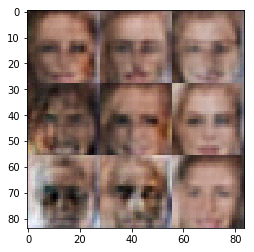

Epoch 1/1... Step 1120 Discriminator Loss: 1.2143... Generator Loss: 1.5275
Epoch 1/1... Step 1140 Discriminator Loss: 1.2775... Generator Loss: 1.3773
Epoch 1/1... Step 1160 Discriminator Loss: 1.3312... Generator Loss: 1.3799
Epoch 1/1... Step 1180 Discriminator Loss: 1.2215... Generator Loss: 2.1928
Epoch 1/1... Step 1200 Discriminator Loss: 1.2280... Generator Loss: 1.5545


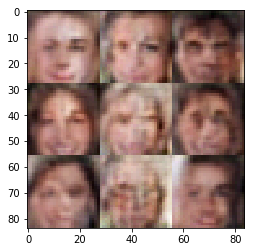

Epoch 1/1... Step 1220 Discriminator Loss: 1.4032... Generator Loss: 0.9094
Epoch 1/1... Step 1240 Discriminator Loss: 1.2333... Generator Loss: 1.2980
Epoch 1/1... Step 1260 Discriminator Loss: 1.2564... Generator Loss: 1.4536
Epoch 1/1... Step 1280 Discriminator Loss: 1.3124... Generator Loss: 1.3079
Epoch 1/1... Step 1300 Discriminator Loss: 1.3782... Generator Loss: 1.2752


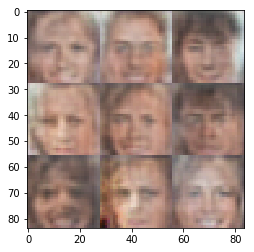

Epoch 1/1... Step 1320 Discriminator Loss: 1.2533... Generator Loss: 1.2068
Epoch 1/1... Step 1340 Discriminator Loss: 1.2639... Generator Loss: 1.1338
Epoch 1/1... Step 1360 Discriminator Loss: 1.2181... Generator Loss: 1.4404
Epoch 1/1... Step 1380 Discriminator Loss: 1.3447... Generator Loss: 1.4109
Epoch 1/1... Step 1400 Discriminator Loss: 1.2402... Generator Loss: 1.4846


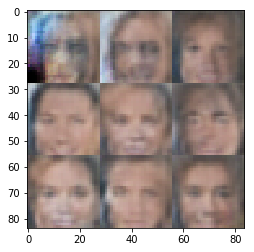

Epoch 1/1... Step 1420 Discriminator Loss: 1.3583... Generator Loss: 1.2221
Epoch 1/1... Step 1440 Discriminator Loss: 1.2003... Generator Loss: 1.6872
Epoch 1/1... Step 1460 Discriminator Loss: 1.1755... Generator Loss: 1.2851
Epoch 1/1... Step 1480 Discriminator Loss: 1.2241... Generator Loss: 1.7775
Epoch 1/1... Step 1500 Discriminator Loss: 1.3890... Generator Loss: 0.8772


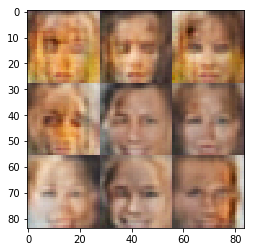

Epoch 1/1... Step 1520 Discriminator Loss: 1.0540... Generator Loss: 2.0260
Epoch 1/1... Step 1540 Discriminator Loss: 1.3691... Generator Loss: 1.0656
Epoch 1/1... Step 1560 Discriminator Loss: 1.3521... Generator Loss: 1.0914
Epoch 1/1... Step 1580 Discriminator Loss: 1.2429... Generator Loss: 1.6083
Epoch 1/1... Step 1600 Discriminator Loss: 1.2189... Generator Loss: 1.0338


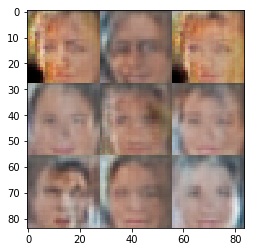

Epoch 1/1... Step 1620 Discriminator Loss: 1.1724... Generator Loss: 1.4190
Epoch 1/1... Step 1640 Discriminator Loss: 1.2812... Generator Loss: 1.4202
Epoch 1/1... Step 1660 Discriminator Loss: 1.2952... Generator Loss: 1.4597
Epoch 1/1... Step 1680 Discriminator Loss: 1.1429... Generator Loss: 1.6458
Epoch 1/1... Step 1700 Discriminator Loss: 1.3739... Generator Loss: 1.3555


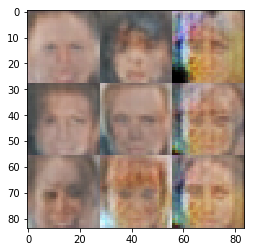

Epoch 1/1... Step 1720 Discriminator Loss: 1.3997... Generator Loss: 1.2783
Epoch 1/1... Step 1740 Discriminator Loss: 1.3231... Generator Loss: 0.9670
Epoch 1/1... Step 1760 Discriminator Loss: 1.1882... Generator Loss: 1.2938
Epoch 1/1... Step 1780 Discriminator Loss: 1.2635... Generator Loss: 1.1790
Epoch 1/1... Step 1800 Discriminator Loss: 1.2237... Generator Loss: 1.5088


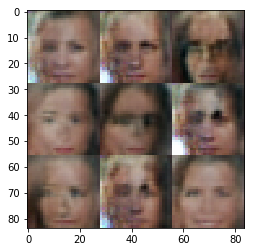

Epoch 1/1... Step 1820 Discriminator Loss: 1.2833... Generator Loss: 1.2518
Epoch 1/1... Step 1840 Discriminator Loss: 1.2367... Generator Loss: 0.9933
Epoch 1/1... Step 1860 Discriminator Loss: 1.2427... Generator Loss: 1.5166
Epoch 1/1... Step 1880 Discriminator Loss: 1.4061... Generator Loss: 1.1190
Epoch 1/1... Step 1900 Discriminator Loss: 1.2200... Generator Loss: 1.5508


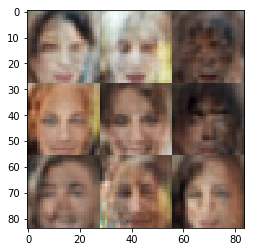

Epoch 1/1... Step 1920 Discriminator Loss: 1.3098... Generator Loss: 1.2542
Epoch 1/1... Step 1940 Discriminator Loss: 1.3969... Generator Loss: 1.2840
Epoch 1/1... Step 1960 Discriminator Loss: 1.2297... Generator Loss: 1.4358
Epoch 1/1... Step 1980 Discriminator Loss: 1.3163... Generator Loss: 1.0930
Epoch 1/1... Step 4480 Discriminator Loss: 1.4283... Generator Loss: 0.7826
Epoch 1/1... Step 4500 Discriminator Loss: 1.4045... Generator Loss: 0.8066


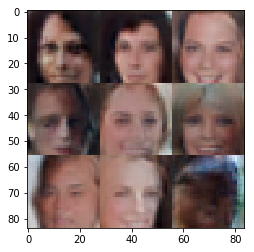

Epoch 1/1... Step 4520 Discriminator Loss: 1.3877... Generator Loss: 0.7981
Epoch 1/1... Step 4540 Discriminator Loss: 1.3802... Generator Loss: 0.8488
Epoch 1/1... Step 4560 Discriminator Loss: 1.4093... Generator Loss: 0.7727
Epoch 1/1... Step 4580 Discriminator Loss: 1.3888... Generator Loss: 0.8376
Epoch 1/1... Step 4600 Discriminator Loss: 1.3937... Generator Loss: 0.8149


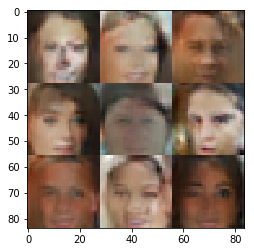

Epoch 1/1... Step 4620 Discriminator Loss: 1.3802... Generator Loss: 0.7867
Epoch 1/1... Step 4640 Discriminator Loss: 1.4126... Generator Loss: 0.7563
Epoch 1/1... Step 4660 Discriminator Loss: 1.3928... Generator Loss: 0.7770
Epoch 1/1... Step 4680 Discriminator Loss: 1.3442... Generator Loss: 0.7837
Epoch 1/1... Step 4700 Discriminator Loss: 1.3457... Generator Loss: 0.8456


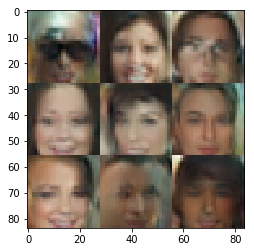

Epoch 1/1... Step 4720 Discriminator Loss: 1.3912... Generator Loss: 0.7693
Epoch 1/1... Step 4740 Discriminator Loss: 1.4166... Generator Loss: 0.7814
Epoch 1/1... Step 4760 Discriminator Loss: 1.3985... Generator Loss: 0.7455
Epoch 1/1... Step 4780 Discriminator Loss: 1.3802... Generator Loss: 0.7675
Epoch 1/1... Step 4800 Discriminator Loss: 1.3802... Generator Loss: 0.7433


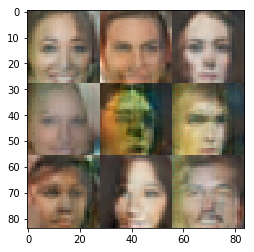

Epoch 1/1... Step 4820 Discriminator Loss: 1.3718... Generator Loss: 0.8088
Epoch 1/1... Step 4840 Discriminator Loss: 1.3534... Generator Loss: 0.8002
Epoch 1/1... Step 4860 Discriminator Loss: 1.3760... Generator Loss: 0.8066
Epoch 1/1... Step 4880 Discriminator Loss: 1.4737... Generator Loss: 0.6936
Epoch 1/1... Step 4900 Discriminator Loss: 1.3950... Generator Loss: 0.7957


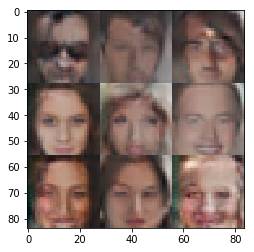

Epoch 1/1... Step 4920 Discriminator Loss: 1.3774... Generator Loss: 0.7595
Epoch 1/1... Step 4940 Discriminator Loss: 1.3965... Generator Loss: 0.7607
Epoch 1/1... Step 4960 Discriminator Loss: 1.3895... Generator Loss: 0.7700
Epoch 1/1... Step 4980 Discriminator Loss: 1.3940... Generator Loss: 0.7419
Epoch 1/1... Step 5000 Discriminator Loss: 1.3844... Generator Loss: 0.7942


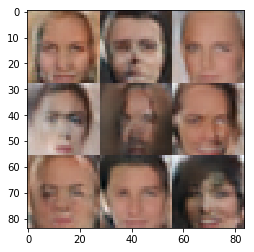

Epoch 1/1... Step 5020 Discriminator Loss: 1.4044... Generator Loss: 0.7435
Epoch 1/1... Step 5040 Discriminator Loss: 1.4051... Generator Loss: 0.7743
Epoch 1/1... Step 5060 Discriminator Loss: 1.3879... Generator Loss: 0.7748
Epoch 1/1... Step 5080 Discriminator Loss: 1.3747... Generator Loss: 0.7269
Epoch 1/1... Step 5100 Discriminator Loss: 1.3988... Generator Loss: 0.8025


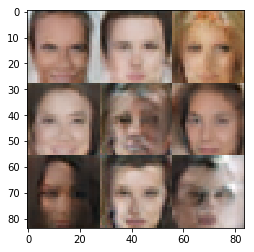

Epoch 1/1... Step 5120 Discriminator Loss: 1.3697... Generator Loss: 0.7952
Epoch 1/1... Step 5140 Discriminator Loss: 1.3650... Generator Loss: 0.7858
Epoch 1/1... Step 5160 Discriminator Loss: 1.4345... Generator Loss: 0.7536
Epoch 1/1... Step 5180 Discriminator Loss: 1.3949... Generator Loss: 0.7668
Epoch 1/1... Step 5200 Discriminator Loss: 1.4051... Generator Loss: 0.7653


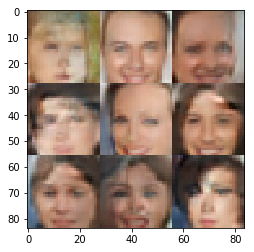

Epoch 1/1... Step 5220 Discriminator Loss: 1.3699... Generator Loss: 0.7545
Epoch 1/1... Step 5240 Discriminator Loss: 1.4314... Generator Loss: 0.6987
Epoch 1/1... Step 5260 Discriminator Loss: 1.3939... Generator Loss: 0.8014
Epoch 1/1... Step 5280 Discriminator Loss: 1.3938... Generator Loss: 0.8005
Epoch 1/1... Step 5300 Discriminator Loss: 1.3771... Generator Loss: 0.8103


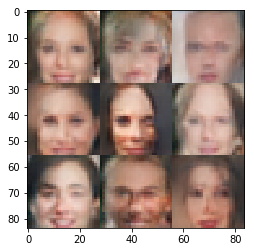

Epoch 1/1... Step 5320 Discriminator Loss: 1.3542... Generator Loss: 0.7863
Epoch 1/1... Step 5340 Discriminator Loss: 1.3910... Generator Loss: 0.7881
Epoch 1/1... Step 5360 Discriminator Loss: 1.4088... Generator Loss: 0.7780
Epoch 1/1... Step 5380 Discriminator Loss: 1.4096... Generator Loss: 0.7759
Epoch 1/1... Step 5400 Discriminator Loss: 1.4012... Generator Loss: 0.7541


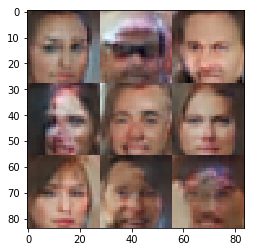

Epoch 1/1... Step 5420 Discriminator Loss: 1.3627... Generator Loss: 0.8051
Epoch 1/1... Step 5440 Discriminator Loss: 1.3640... Generator Loss: 0.7929
Epoch 1/1... Step 5460 Discriminator Loss: 1.3835... Generator Loss: 0.7878
Epoch 1/1... Step 5480 Discriminator Loss: 1.3764... Generator Loss: 0.7930
Epoch 1/1... Step 5500 Discriminator Loss: 1.4201... Generator Loss: 0.7733


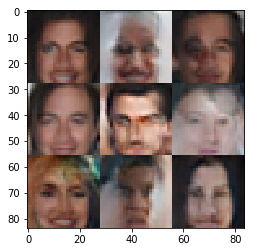

Epoch 1/1... Step 5520 Discriminator Loss: 1.4110... Generator Loss: 0.7468
Epoch 1/1... Step 5540 Discriminator Loss: 1.3839... Generator Loss: 0.7959
Epoch 1/1... Step 5560 Discriminator Loss: 1.3662... Generator Loss: 0.7907
Epoch 1/1... Step 5580 Discriminator Loss: 1.3861... Generator Loss: 0.7924
Epoch 1/1... Step 5600 Discriminator Loss: 1.3986... Generator Loss: 0.8012


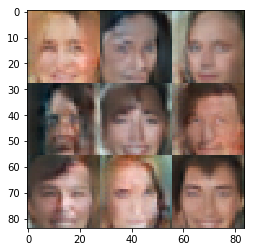

Epoch 1/1... Step 5620 Discriminator Loss: 1.3734... Generator Loss: 0.8133
Epoch 1/1... Step 5640 Discriminator Loss: 1.3640... Generator Loss: 0.7678
Epoch 1/1... Step 5660 Discriminator Loss: 1.3628... Generator Loss: 0.8307
Epoch 1/1... Step 5680 Discriminator Loss: 1.3620... Generator Loss: 0.7824
Epoch 1/1... Step 5700 Discriminator Loss: 1.3745... Generator Loss: 0.8231


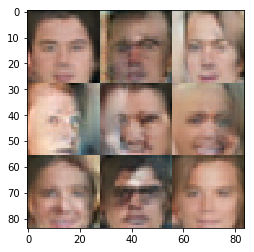

Epoch 1/1... Step 5720 Discriminator Loss: 1.3975... Generator Loss: 0.7596
Epoch 1/1... Step 5740 Discriminator Loss: 1.4053... Generator Loss: 0.7737
Epoch 1/1... Step 5760 Discriminator Loss: 1.3725... Generator Loss: 0.8049
Epoch 1/1... Step 5780 Discriminator Loss: 1.3756... Generator Loss: 0.7832
Epoch 1/1... Step 5800 Discriminator Loss: 1.3825... Generator Loss: 0.7944


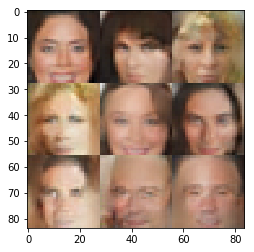

Epoch 1/1... Step 5820 Discriminator Loss: 1.4183... Generator Loss: 0.7462
Epoch 1/1... Step 5840 Discriminator Loss: 1.4202... Generator Loss: 0.7767
Epoch 1/1... Step 5860 Discriminator Loss: 1.3797... Generator Loss: 0.7995
Epoch 1/1... Step 5880 Discriminator Loss: 1.3903... Generator Loss: 0.7754
Epoch 1/1... Step 5900 Discriminator Loss: 1.3996... Generator Loss: 0.7617


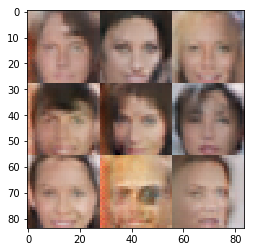

Epoch 1/1... Step 5920 Discriminator Loss: 1.3834... Generator Loss: 0.7842
Epoch 1/1... Step 5940 Discriminator Loss: 1.3869... Generator Loss: 0.7867
Epoch 1/1... Step 5960 Discriminator Loss: 1.3699... Generator Loss: 0.7855
Epoch 1/1... Step 5980 Discriminator Loss: 1.3931... Generator Loss: 0.7912
Epoch 1/1... Step 6000 Discriminator Loss: 1.3855... Generator Loss: 0.7922


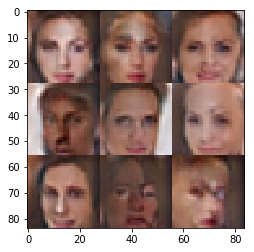

Epoch 1/1... Step 6020 Discriminator Loss: 1.3913... Generator Loss: 0.7746
Epoch 1/1... Step 6040 Discriminator Loss: 1.3729... Generator Loss: 0.7914
Epoch 1/1... Step 6060 Discriminator Loss: 1.3638... Generator Loss: 0.7887
Epoch 1/1... Step 6080 Discriminator Loss: 1.3980... Generator Loss: 0.7890
Epoch 1/1... Step 6100 Discriminator Loss: 1.3959... Generator Loss: 0.7876


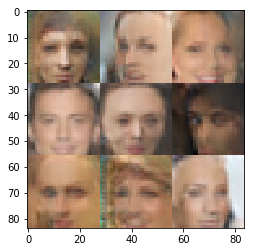

Epoch 1/1... Step 6120 Discriminator Loss: 1.3754... Generator Loss: 0.7968
Epoch 1/1... Step 6140 Discriminator Loss: 1.3830... Generator Loss: 0.8065
Epoch 1/1... Step 6160 Discriminator Loss: 1.3809... Generator Loss: 0.7980
Epoch 1/1... Step 6180 Discriminator Loss: 1.3568... Generator Loss: 0.7878
Epoch 1/1... Step 6200 Discriminator Loss: 1.3953... Generator Loss: 0.7688


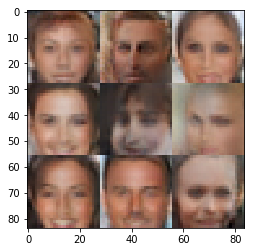

Epoch 1/1... Step 6220 Discriminator Loss: 1.3693... Generator Loss: 0.7751
Epoch 1/1... Step 6240 Discriminator Loss: 1.3958... Generator Loss: 0.7584
Epoch 1/1... Step 6260 Discriminator Loss: 1.4023... Generator Loss: 0.7656
Epoch 1/1... Step 6280 Discriminator Loss: 1.2099... Generator Loss: 0.6730
Epoch 1/1... Step 6300 Discriminator Loss: 1.3421... Generator Loss: 0.7938


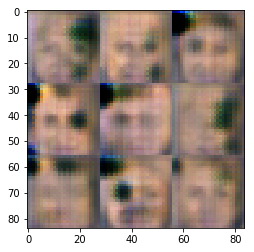

Epoch 1/1... Step 6320 Discriminator Loss: 1.3757... Generator Loss: 0.8528


In [ ]:
batch_size = 32 # see slack #project-5
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.